In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
from matplotlib.animation import FuncAnimation

### Setting up problem

Goal: Simulate a Brownian Oval moving along a tract for a fixed number of timesteps, and be able to both visualise its path and obtain histograms of its movements

Steps to obtain:

1. First I will map the oval moving in its configuration space. Given the parameters of it, we can obtain the space the oval should be moving around in. I'll simulate this first.
2. Obtaining that, I then need to reflect the point in the normal of this boundary space.
3. Finally, having obtained this, I can write a function that maps from the perspective of the point moving about a configuration space, to the perspective of the oval moving about the 1d space.
4. Finally, I'll move to 3d (X, Y, theta)


Relevant formula:

Equation of an ellipse: $\frac{x^2}{a^2} + \frac{y^2}{b^2} = 1$ \
Rightmost point for an ellipse: $(X_r, Y_r)\
$X_r = \sqrt{a^2\cos^2(\theta) + b^2\sin^2(\theta)}$ \
$Y_r = \frac{(a^2 - b^2)\sin(\theta)\cos(\theta)}{X_r}$

Leftmost point for an ellipse: $(-X_r, -Y_r)$

Topmost point for an ellipse: $(X_t, Y_t)$ \
$Y_t = \sqrt{a^2\sin^2(\theta) + b^2\cos^2(\theta)}$ \
$X_t = \frac{(a^2 -b^2) \sin(\theta) \cos(\theta)}{Y_t}$

Bottommost point: $(-X_t, -Y_t)$

These above all assume the ellipse is centred at 0.

Let's compute the boundary. This is for a general case. This took me a surprisingly long time to solve, but it's because there's a couple of things to realise geometrically (for me at least). 
First, my formula assumes that the ellipse is centred at (0,0). I want to obtain the distance from the topmost point to the centre, and the distance from the bottommost point to the centre. These will actually be the same distances, and are just given by:
$|0 - y_t| = |0 - y_b|$

So, I can then obtain that:

Lower computational boundary therefore is: $y = LB + |y_b|$ \
Topmost computational boundary therefore is: $y = UB - |y_t|$

Ok, let's graph what this boundary looks like


(np.float64(4.0), np.float64(0.0)) (np.float64(-4.0), np.float64(-0.0)) (np.float64(0.0), np.float64(2.0)) (np.float64(-0.0), np.float64(-2.0))


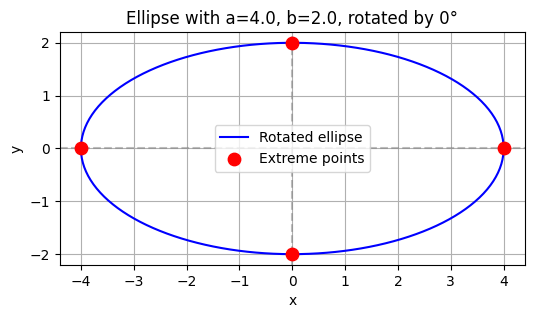

In [25]:
x_rightmost = lambda a, b, theta: np.sqrt(a**2*np.cos(theta)**2 + b**2*np.sin(theta)**2)
y_rightmost = lambda a, b, theta: (a**2 - b**2)*np.sin(theta)*np.cos(theta)/x_rightmost(a, b, theta)

x_leftmost = lambda a, b, theta: -1 * x_rightmost(a, b, theta)
y_leftmost = lambda a, b, theta: -1 * y_rightmost(a, b, theta)

y_topmost = lambda a, b, theta: np.sqrt(a**2*np.sin(theta)**2 + b**2*np.cos(theta)**2)
x_topmost = lambda a, b, theta: (a**2 - b**2) * np.sin(theta)*np.cos(theta)/y_topmost(a,b,theta)

y_bottommost = lambda a, b, theta: -1 * y_topmost(a, b, theta)
x_bottommost = lambda a, b, theta: -1 * x_topmost(a, b, theta)


# Verify these functions work visually real quick
def ellipse_extremes_analytic(a, b, theta_deg):
    """
    Returns the four extreme points on the rotated ellipse using
    closed-form expressions:
      (xR, yR) -> rightmost
      (xL, yL) -> leftmost
      (xT, yT) -> topmost
      (xB, yB) -> bottommost
    """
    theta = np.radians(theta_deg)

    # Rightmost (max x)
    xR = x_rightmost(a, b, theta)
    yR = y_rightmost(a, b, theta)
    
    # Leftmost (min x)
    xL = x_leftmost(a, b, theta)
    yL = y_leftmost(a, b, theta)
    
    # Topmost (max y)
    yT = y_topmost(a, b, theta)
    xT = x_topmost(a, b, theta)
    
    # Bottommost (min y)
    yB = y_bottommost(a, b, theta)
    xB = x_bottommost(a, b, theta)
    print((xR, yR), (xL, yL), (xT, yT), (xB, yB))
    return (xR, yR), (xL, yL), (xT, yT), (xB, yB)

def ellipse_parametric(a, b, theta_deg, num_pts=300):

    theta = np.radians(theta_deg)
    
    # Parametrize unrotated ellipse
    t = np.linspace(0, 2*np.pi, num_pts)
    x_prim = a * np.cos(t)
    y_prim = b * np.sin(t)
    
    # Rotation matrix
    R = np.array([[np.cos(theta), -np.sin(theta)],
                  [np.sin(theta),  np.cos(theta)]])
    
    # Rotate points
    xy_rot = R @ np.vstack((x_prim, y_prim))  # shape (2, num_pts)
    return xy_rot[0], xy_rot[1]

def plot_rotated_ellipse_analytic_extremes(a, b, theta_deg):
    """
    Plots the rotated ellipse (a,b,theta_deg) and marks
    the four extreme points using the closed-form formulas.
    """
    # 1) Generate the ellipse points for plotting
    x_vals, y_vals = ellipse_parametric(a, b, theta_deg)
    
    # 2) Compute the four extreme points analytically
    (xR, yR), (xL, yL), (xT, yT), (xB, yB) = ellipse_extremes_analytic(a, b, theta_deg)
    
    # 3) Plot
    plt.figure(figsize=(6,6))
    plt.plot(x_vals, y_vals, 'b-', label="Rotated ellipse")
    
    # Plot extreme points in red
    plt.scatter([xR, xL, xT, xB],
                [yR, yL, yT, yB],
                color='red', s=80, zorder=3,
                label="Extreme points")
    
    # Axes lines
    plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
    plt.axvline(0, color='gray', linestyle='--', alpha=0.5)
    
    plt.gca().set_aspect('equal', 'box')
    plt.title(f"Ellipse with a={a}, b={b}, rotated by {theta_deg}°")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    plt.legend()
    plt.show()

a = 4.0
b = 2.0
theta_deg = 0
plot_rotated_ellipse_analytic_extremes(a, b, theta_deg)



Beautiful, those functions work. Now I need to construct the effective domain. Let's try and do that

Some coding later: 


Ok, now I have the domain functions all correct as functions of theta, a and b. Next I want to find a function to calculate to the normal to the upper and lower boundaries. The right and left boundaries should be periodic.

Bottom boundary is given by:
\begin{align}
    y &= y_{min} + |y_b(\theta)| \\
    F(y, \theta) &= y - y_{min} + |y_b(\theta)| = 0
\end{align}

Normal to this is given by:
\begin{align}
    \hat{n} = \begin{bmatrix}
        \frac{\sin(\theta)\cos(\theta)(b^2 - a^2)}{\sqrt{a^2cos^2(\theta) + b^2\cos^2(\theta)}} \\
        1\\ 
        \end{bmatrix}
\end{align}


So normal along bottom is:


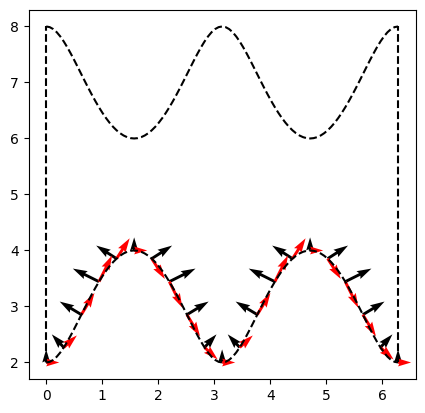

In [26]:
H = 10 # height/distance of upper bound from lower bound
a = 4
b = 2


y = np.linspace(0, 10, 101)
theta = np.linspace(0, 2*np.pi, 101)
upper_bound = np.array([H  - abs(y_topmost(a, b, th)) for th in theta])
lower_bound = np.array([0 + abs(y_topmost(a, b, th)) for th in theta]) # 0 because I implicitly assume that the lower bound is 0

normal_angle = lambda a, b, theta: (np.cos(theta)*np.sin(theta)*(b**2 - a**2))/ \
    (np.sqrt(a**2*np.cos(theta)**2 + b**2*np.sin(theta)**2))
theta_norm = np.linspace(0, 2*np.pi, 21)
y_norm = np.array([abs(y_topmost(a, b, th)) for th in theta_norm])
normal_vectors = np.array([[normal_angle(a, b, th), 1] for th in theta_norm])
tangent_vectors = np.array([[1, -normal_angle(a, b, th)] for th in theta_norm])

fig, ax = plt.subplots()
ax.plot(theta, upper_bound, linestyle='--', color='black')
ax.plot(theta, lower_bound, linestyle='--', color='black')
ax.vlines([0, np.pi*2], ymin=(0 - y_bottommost(a, b, 0)), ymax=H - y_topmost(a, b, 0), linestyles='--', color='black')
ax.quiver(theta_norm, y_norm, normal_vectors[:, 0], normal_vectors[:, 1])
ax.quiver(theta_norm, y_norm, tangent_vectors[:, 0], tangent_vectors[:, 1], color='red')
# ax.xlabel("theta")
# ax.ylabel("y")
ax.set_aspect('equal')



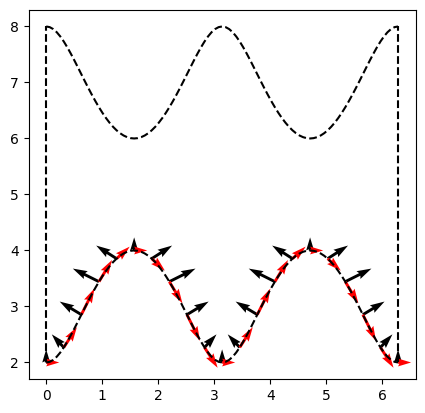

In [36]:
H = 10 # height/distance of upper bound from lower bound
a = 4
b = 2

def numerical_derivative(a, b, theta, func, h=1e-5):
    f_plus = func(a, b, theta + h)
    f_minus = func(a, b, theta - h)
    return (f_plus - f_minus)/(2*h)

y = np.linspace(0, 10, 101)
theta = np.linspace(0, 2*np.pi, 101)
upper_bound = np.array([H  - abs(y_topmost(a, b, th)) for th in theta])
lower_bound = np.array([0 + abs(y_topmost(a, b, th)) for th in theta]) # 0 because I implicitly assume that the lower bound is 0

normal_angle = lambda a, b, theta: (np.cos(theta)*np.sin(theta)*(b**2 - a**2))/ \
    (np.sqrt(a**2*np.cos(theta)**2 + b**2*np.sin(theta)**2))
theta_norm = np.linspace(0, 2*np.pi, 21)
y_norm = np.array([abs(y_topmost(a, b, th)) for th in theta_norm])
normal_vectors = np.array([[normal_angle(a, b, th), 1] for th in theta_norm])
tangent_vectors = np.array([[1, -numerical_derivative(a, b, th, y_bottommost)] for th in theta_norm])

fig, ax = plt.subplots()
ax.plot(theta, upper_bound, linestyle='--', color='black')
ax.plot(theta, lower_bound, linestyle='--', color='black')
ax.vlines([0, np.pi*2], ymin=(0 - y_bottommost(a, b, 0)), ymax=H - y_topmost(a, b, 0), linestyles='--', color='black')
ax.quiver(theta_norm, y_norm, normal_vectors[:, 0], normal_vectors[:, 1])
ax.quiver(theta_norm, y_norm, tangent_vectors[:, 0], tangent_vectors[:, 1], color='red')
# ax.xlabel("theta")
# ax.ylabel("y")
ax.set_aspect('equal')



Next, I want to reflect something in the normal when it comes into contact with that point. What is the best way to achieve that?

Let's first construct a hypothetical move a point will make across a boundary, and then extrapolate from there. 

So let's place a point at $(2, 4)$, and then let's make $(d\theta, dy) = (0.3, -1.2)$

This will cross the boundary. Let's visualise that, and then solve for the exact moment it hits the boundary.

Text(0, 0.5, 'y')

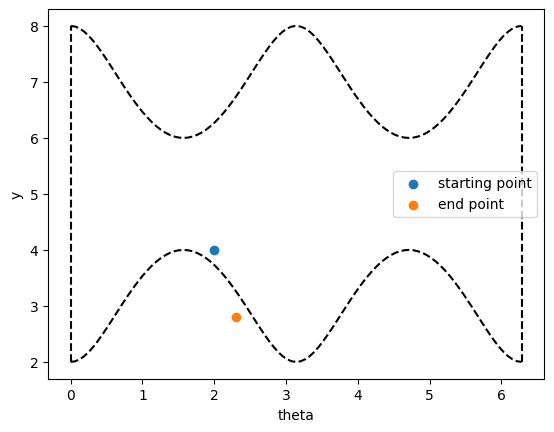

In [27]:
p0 = np.array([2, 4])
delta = np.array([0.3, -1.2])
p1 = p0 + delta
plt.plot(theta, upper_bound, linestyle='--', color='black')
plt.plot(theta, lower_bound, linestyle='--', color='black')
plt.scatter(p0[0], p0[1], label='starting point')
plt.scatter(p1[0], p1[1], label='end point')
plt.vlines([0, np.pi*2], ymin=(0 - y_bottommost(a, b, 0)), ymax=H - y_topmost(a, b, 0), linestyles='--', color='black')
# plt.quiver(theta_norm, y_norm, normal_vectors[:, 0], normal_vectors[:, 1])
plt.xlabel("theta")
plt.legend()
plt.ylabel("y")

Now I want to identify exactly when this point hits the boundary in the same way Oscar did

Text(0, 0.5, 'y')

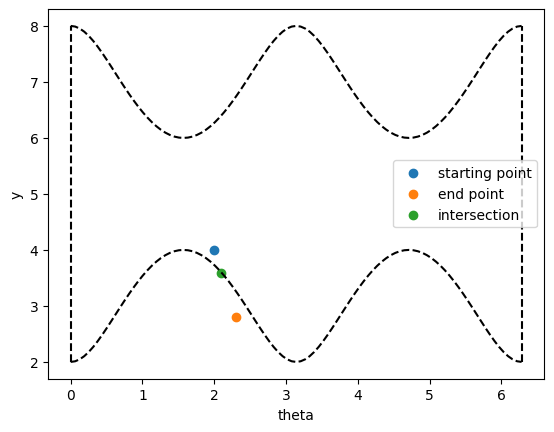

In [28]:
# How to find intersection? We solve for where the intersection between the lower boundary
# and the particle intercept. This will be where y +tdy = f(theta + tdtheta), where we vary t
lower_boundary = lambda theta: abs(y_topmost(4, 2, theta)) # hard coded to correspond to this space
def find_intersection(p0, p1, boundary_function):
    # Define the quantities I'm going to need
    theta0, theta1= p0[0], p1[0]
    dtheta  = theta1-theta0
    y0, y1 = p0[1], p1[1]
    dy = y1 - y0

    # Define a function to solve for when the position of point and boundary cross
    def error(t):
        error = boundary_function(theta0 + t*dtheta) - (y0 + t*dy)
        return error
    solution = root_scalar(error, bracket=[0,1], method='bisect')

    if solution.converged:
        t_sol = solution.root
        theta_sol = theta0 + t_sol*dtheta
        y_sol = y0 + t_sol*dy
        collision_point = np.array([theta_sol, y_sol])
        return collision_point

intersection = find_intersection(p0, p1, lower_boundary)

plt.plot(theta, upper_bound, linestyle='--', color='black')
plt.plot(theta, lower_bound, linestyle='--', color='black')
plt.scatter(p0[0], p0[1], label='starting point')
plt.scatter(p1[0], p1[1], label='end point')
plt.scatter(intersection[0], intersection[1], label='intersection')
plt.vlines([0, np.pi*2], ymin=(0 - y_bottommost(a, b, 0)), ymax=H - y_topmost(a, b, 0), linestyles='--', color='black')
# plt.quiver(theta_norm, y_norm, normal_vectors[:, 0], normal_vectors[:, 1])
plt.xlabel("theta")
plt.legend()
plt.ylabel("y")

Now I want to reflect the excess movement from that point back into the region. How to achieve that?

I don't quite understand what his maths is telling me, but first I'll check what it does, and check it is actually reflecting the excess movement.

Text(0, 0.5, 'y')

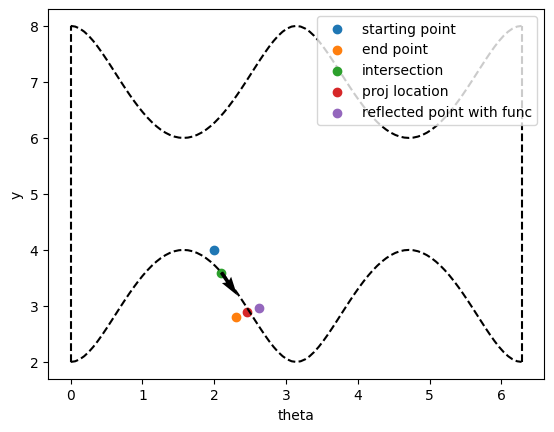

In [33]:
lower_boundary_deriv = lambda theta: normal_angle(4, 2, theta)
theta_intersect = intersection[0]
tangent = np.array([1, -lower_boundary_deriv(theta_intersect)])
tangent = tangent/np.linalg.norm(tangent)
proj = intersection + np.dot(p1 - intersection, tangent)*tangent
reflection = 2 * proj - p1

def numerical_derivative(a, b, theta, func, h=1e-5):
    f_plus = func(theta + h)
    f_minus = func(theta - h)
    return (f_plus - f_minus)/(2*h)

def give_reflection(p_intersect, p1, boundary_func_deriv):
    theta_intersect = p_intersect[0]
    tangent = np.array([1, -boundary_func_deriv(theta_intersect)])
    tangent = tangent/np.linalg.norm(tangent)
    projection = p_intersect + np.dot(p1 - p_intersect, tangent) * tangent
    reflection = 2 * projection - p1
    return reflection

test_reflection = give_reflection(intersection, p1, lower_boundary_deriv)

tangent = np.array([1, numerical_derivative(4, 2, theta_intersect, lower_boundary)])
plt.plot(theta, upper_bound, linestyle='--', color='black')
plt.plot(theta, lower_bound, linestyle='--', color='black')
plt.scatter(p0[0], p0[1], label='starting point')
plt.scatter(p1[0], p1[1], label='end point')
plt.scatter(intersection[0], intersection[1], label='intersection')
plt.scatter(proj[0], proj[1], label='proj location')
# plt.scatter(reflection[0], reflection[1], label='reflected point')
plt.scatter(test_reflection[0], test_reflection[1], label='reflected point with func')
plt.vlines([0, np.pi*2], ymin=(0 - y_bottommost(a, b, 0)), ymax=H - y_topmost(a, b, 0), linestyles='--', color='black')
plt.quiver(intersection[0], intersection[1], tangent[0], tangent[1])
plt.xlabel("theta")
plt.legend(loc='upper right')
plt.ylabel("y")

Ok yes, this all makes sense. So, steps are:

Have the ball move around the system according to our dynamics. Have an if statement for each timestep. If the final position crosses our boundaries, then we do the above step to reflect it **in the tangent at the point where the ball intersected with the boundary**. I also need to impose the periodic boundary conditions on theta, but that's fine. 

Let's try and do this for a first simulation.

In [15]:

# y = np.linspace(0, 10, 101)
# theta = np.linspace(0, 2*np.pi, 101)
# upper_bound = np.array([H  - abs(y_topmost(a, b, th)) for th in theta])
# lower_bound = np.array([0 + abs(y_topmost(a, b, th)) for th in theta]) # 0 because I implicitly assume that the lower bound is 0

# Problem setup i.e. boundary conditions, cell dimensions
H = 10
W = 2*np.pi
a = 4
b = 2
oval_vert_dist = lambda a, b, theta: abs(np.sqrt(a**2*np.sin(theta)**2 + b**2*np.cos(theta)**2))
lower_bound = lambda a, b, theta: 0 + oval_vert_dist(a, b, theta)
upper_bound = lambda a, b, theta: H - oval_vert_dist(a, b, theta)
lower_bound_deriv = lambda a, b, theta: (np.cos(theta)*np.sin(theta)*(b**2 - a**2))/ \
    (np.sqrt(a**2*np.cos(theta)**2 + b**2*np.sin(theta)**2))
upper_bound_deriv = lambda a, b, theta: lower_bound_deriv(a, b, theta) * -1
# Uncomment below lines if I want to view the setup
# thetas = np.linspace(0, W, 101)
# plt.plot(thetas, [lower_bound(a, b, theta) for theta in thetas], linestyle='--')
# plt.plot(thetas, [upper_bound(a, b, theta) for theta in thetas], linestyle='--')
# plt.vlines([0, W], ymin=2, ymax=8, linestyle='--')
# plt.plot()

def find_intersection(p0, p1, boundary_function):
    # Define the quantities I'm going to need
    theta0, theta1 = p0[0], p1[0]
    dtheta  = theta1-theta0
    y0, y1 = p0[1], p1[1]
    dy = y1 - y0

    # Define a function to solve for when the position of point and boundary cross
    def error(t):
        error = boundary_function(a, b, theta0 + t*dtheta) - (y0 + t*dy)
        return error
    solution = root_scalar(error, bracket=[0,1], method='bisect')

    if solution.converged:
        t_sol = solution.root
        theta_sol = theta0 + t_sol*dtheta
        y_sol = y0 + t_sol*dy
        collision_point = np.array([theta_sol, y_sol])
        return collision_point

def give_reflection(p_intersect, p1, boundary_func_deriv):
    theta_intersect = p_intersect[0]
    tangent = np.array([1, -boundary_func_deriv(a, b, theta_intersect)[0]]).reshape((2,1))
    tangent = tangent/np.linalg.norm(tangent)
    projection = p_intersect + np.dot((p1 - p_intersect).T, tangent) * tangent
    reflection = 2 * projection - p1
    return reflection

# Initial conditions and cell parameters
y0 = H/2
theta0 = W/2
U = 1.0 # Velocity
D_T = 1e-3     # Translational diffusivity
D_R = 0.1      # Rotational diffusivity
dt = 0.1
brownian_step = np.sqrt(2 * D_T * dt)
brownian_r_step = np.sqrt(2 * D_R * dt)
T = 100.0      # Total simulation time
steps = int(T / dt)
X0 = np.array([theta0, y0])

# Run simulation

def simulate(X0, lower_bound_func, lower_bound_func_deriv, upper_bound_func, 
             upper_bound_func_deriv):
    trajectory = np.zeros((steps, 2))
    trajectory[0, :] = X0
    for step in range(steps-1):
        print(step)
        p_now = trajectory[step, :]
        theta_now = p_now[0]
        y_now = p_now[1]

        dy = U*np.sin(theta_now) * dt + brownian_step*np.random.randn(1)
        dtheta = brownian_r_step * np.random.randn(1)

        y_next = y_now + dy
        theta_next = theta_now + dtheta
        theta_next = theta_next % (2 * np.pi) # Reflective boundary conditions
        p_next = np.array([theta_next, y_next])
        
        if y_next - lower_bound_func(a, b, theta_next) < 0:
            print("lower bound violated")
            p_intersect = find_intersection(p_now, p_next, lower_bound_func)
            p_reflect = give_reflection(p_intersect, p_next, lower_bound_func_deriv)
            p_next = p_reflect

        elif y_next - upper_bound_func(a, b, theta_next) > 0:
            print("upper bound violated")
            p_intersect = find_intersection(p_now, p_next, upper_bound_func)
            p_reflect = give_reflection(p_intersect, p_next, upper_bound_func_deriv)
            p_next = p_reflect

        
        
        trajectory[step + 1, :] = p_next.reshape(2,)
    return trajectory

trajectory = simulate(X0, lower_bound, lower_bound_deriv, upper_bound, upper_bound_deriv)
                      



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

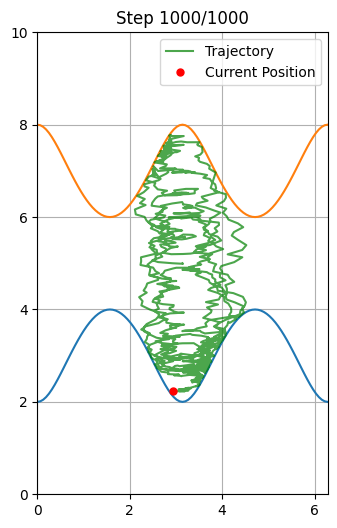

In [28]:
from IPython.display import display, clear_output
import time

def animate_trajectory(trajectory, lower_bounds=None, upper_bounds=None, xlim=None, ylim=None, dt=0.05):
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(6, 6))

    # Set axis limits
    if xlim is None:
        xlim = (np.min(trajectory[:, 0]) - 1, np.max(trajectory[:, 0]) + 1)
    if ylim is None:
        ylim = (np.min(trajectory[:, 1]) - 1, np.max(trajectory[:, 1]) + 1)

    for step_i in range(len(trajectory)):
        # Clear previous frame
        clear_output(wait=True)
        ax.clear()
        # Extract x and y positions
        x_vals = trajectory[:step_i+1, 0]
        y_vals = trajectory[:step_i+1, 1]
        x, y = trajectory[step_i]  # Current position

        # plot bounds
        if lower_bound is not None:
            ax.plot(lower_bounds[0], lower_bounds[1])
        
        if upper_bound is not None:
            ax.plot(upper_bounds[0], upper_bounds[1])

        # Plot trajectory
        ax.plot(x_vals, y_vals, 'g-', lw=1.5, alpha=0.7, label="Trajectory")  # Past trajectory
        ax.plot(x, y, 'ro', ms=5, label="Current Position")  # Moving point
        
        # Set limits and labels
        ax.set_xlim(*xlim)
        ax.set_ylim(*ylim)
        ax.set_aspect('equal', 'box')
        ax.set_title(f"Step {step_i+1}/{len(trajectory)}")
        ax.legend()
        ax.grid(True)
        
        # Display updated figure
        display(fig)
        time.sleep(dt)  # Control animation speed

    plt.close(fig)  # Close figure after animation completes

x_grid = np.linspace(0, 2*np.pi, 101)

animate_trajectory(trajectory, lower_bounds=[x_grid, lower_bound(a, b, x_grid)], upper_bounds=[x_grid, upper_bound(a, b, x_grid)],
                    xlim=[0, 2*np.pi], ylim=[0, H])



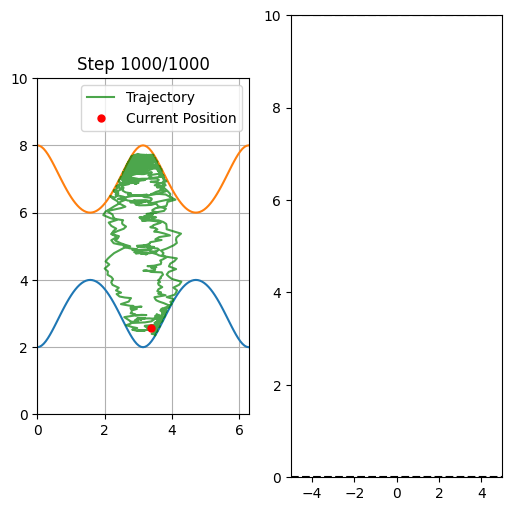

In [5]:
from IPython.display import display, clear_output
import time

def build_oval(x_coords, y_coords, theta=0, y=0):

    c, s = np.cos(theta), np.sin(theta)
    x_coords_rot = c * x_coords - s * y_coords
    y_coords_rot = s * x_coords + c * y_coords
    y_coords_rot += y
    return x_coords_rot, y_coords_rot



def animate_trajectory_2(trajectory, lower_bounds=None, upper_bounds=None, xlim=None, ylim=None, dt=0.05):
    
    # Create figure and axis
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 6))

    # Set axis limits
    if xlim is None:
        xlim = (np.min(trajectory[:, 0]) - 1, np.max(trajectory[:, 0]) + 1)
    if ylim is None:
        ylim = (np.min(trajectory[:, 1]) - 1, np.max(trajectory[:, 1]) + 1)

    # Construct oval points
    t = np.linspace(0, 2*np.pi, 360)
    oval_x = a * np.cos(t)
    oval_y = b * np.sin(t)

    for step_i in range(len(trajectory)):
        # Clear previous frame
        clear_output(wait=True)
        ax1.clear()
        ax2.clear()
        # Extract x and y positions
        theta_vals = trajectory[:step_i+1, 0]
        y_vals = trajectory[:step_i+1, 1]
        theta, y = trajectory[step_i]  # Current position

        # plot bounds
        if lower_bound is not None:
            ax1.plot(lower_bounds[0], lower_bounds[1])
            ax2.hlines(0, -5, 5, color='black', linestyle='--')
        
        if upper_bound is not None:
            ax1.plot(upper_bounds[0], upper_bounds[1])
            ax2.hlines(H, -5, 5, color='black', linestyle='--')

        # Plot the trajectory in parameter space
        ax1.plot(theta_vals, y_vals, 'g-', lw=1.5, alpha=0.7, label="Trajectory")  # Past trajectory
        ax1.plot(theta, y, 'ro', ms=5, label="Current Position")  # Moving point

        # Plot the Oval moving around in the real space
        oval_x, oval_y = build_oval(oval_x, oval_y, theta, y)
        ax2.plot(oval_x, oval_y)
        
        # Set limits and labels
        ax1.set_xlim(*xlim)
        ax1.set_ylim(*ylim)
        ax2.set_xlim(*[-5, 5])
        ax2.set_ylim(*ylim)
        ax1.set_aspect('equal', 'box')
        ax1.set_title(f"Step {step_i+1}/{len(trajectory)}")
        ax1.legend()
        ax1.grid(True)
        
        # Display updated figure
        display(fig)
        time.sleep(dt)  # Control animation speed

    plt.close(fig)  # Close figure after animation completes

x_grid = np.linspace(0, 2*np.pi, 101)

animate_trajectory_2(trajectory, lower_bounds=[x_grid, lower_bound(a, b, x_grid)],
                    upper_bounds=[x_grid, upper_bound(a, b, x_grid)], xlim=[0, 2*np.pi],
                    ylim=[0, H])

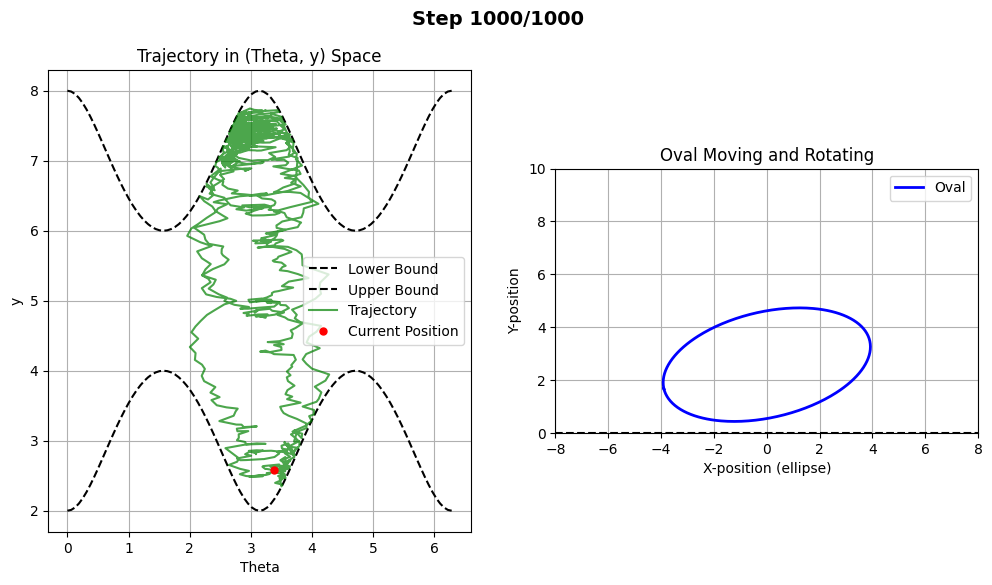

In [13]:
def build_oval(a, b, theta=0, y=0):
    """Generates the coordinates for an oval rotated by theta and shifted to height y."""
    t = np.linspace(0, 2 * np.pi, 360)  # Parametric angle
    x_coords = a * np.cos(t)  # Ellipse x-coordinates
    y_coords = b * np.sin(t)  # Ellipse y-coordinates

    # Apply rotation matrix
    c, s = np.cos(theta), np.sin(theta)
    x_coords_rot = c * x_coords - s * y_coords
    y_coords_rot = s * x_coords + c * y_coords

    # Translate vertically to match y-position
    y_coords_rot += y  

    return x_coords_rot, y_coords_rot

def animate_trajectory_and_oval(trajectory, a=1, b=0.5, lower_bounds=None, upper_bounds=None, xlim=None, ylim=None, dt=0.05):

    # Create figure and axes for side-by-side animation
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Set axis limits
    if xlim is None:
        xlim = (np.min(trajectory[:, 0]) - 1, np.max(trajectory[:, 0]) + 1)
    if ylim is None:
        ylim = (np.min(trajectory[:, 1]) - 1, np.max(trajectory[:, 1]) + 1)
    
    ax1.set_xlim(*xlim)
    ax1.set_ylim(*ylim)
    ax2.set_xlim(-2*a, 2*a)  # Adjust horizontal limits based on oval size
    ax2.set_ylim(*ylim)

    for step_i in range(len(trajectory)):
        # Clear previous frame
        clear_output(wait=True)
        ax1.clear()
        ax2.clear()

        # Update oval plot bounds in loop
        ax2.set_xlim(-2*a, 2*a)  # Adjust horizontal limits based on oval size
        ax2.set_ylim(*ylim)

        # Extract current values
        theta, y = trajectory[step_i]

        # Extract trajectory so far
        x_vals = trajectory[:step_i+1, 0]
        y_vals = trajectory[:step_i+1, 1]

        # Plot bounds on trajectory space
        if lower_bounds is not None:
            ax1.plot(lower_bounds[0], lower_bounds[1], 'k--', label="Lower Bound")
        
        if upper_bounds is not None:
            ax1.plot(upper_bounds[0], upper_bounds[1], 'k--', label="Upper Bound")

        # Plot the trajectory in (theta, y) space
        ax1.plot(x_vals, y_vals, 'g-', lw=1.5, alpha=0.7, label="Trajectory")  # Past trajectory
        ax1.plot(theta, y, 'ro', ms=5, label="Current Position")  # Moving point

        # Generate and plot the oval in real space
        oval_x, oval_y = build_oval(a, b, theta, y)
        ax2.plot(oval_x, oval_y, 'b-', lw=2, label="Oval")
        ax2.axhline(0, color='black', linestyle='--')  # Reference line

        # Set titles and labels
        ax1.set_title("Trajectory in (Theta, y) Space")
        ax1.set_xlabel("Theta")
        ax1.set_ylabel("y")
        ax1.legend()
        ax1.grid(True)

        ax2.set_title("Oval Moving and Rotating")
        ax2.set_xlabel("X-position (ellipse)")
        ax2.set_ylabel("Y-position")
        ax2.set_aspect('equal', 'box')
        ax2.legend()
        ax2.grid(True)

        # title
        fig.suptitle(f"Step {step_i+1}/{len(trajectory)}", fontsize=14, fontweight='bold')

        # Display updated figure
        display(fig)
        time.sleep(dt)  # Control animation speed

    plt.close(fig)  # Close figure after animation completes


animate_trajectory_and_oval(trajectory, a=a, b=b, lower_bounds=[x_grid, lower_bound(a, b, x_grid)],
                            upper_bounds=[x_grid, upper_bound(a, b, x_grid)], xlim=[-5, 5], ylim=[0,10],
                            dt=0.01)

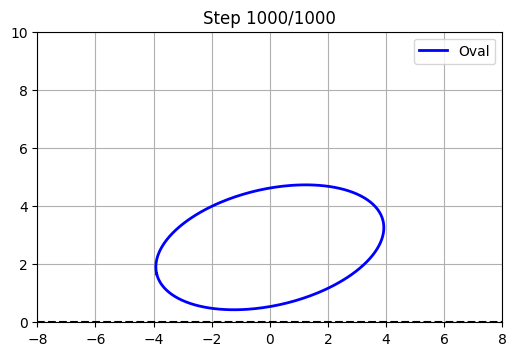

In [8]:
from IPython.display import display, clear_output
import numpy as np
import matplotlib.pyplot as plt
import time

def build_oval(a, b, theta=0, y=0):
    """Generates the coordinates for an oval rotated by theta and shifted to height y."""
    t = np.linspace(0, 2 * np.pi, 360)  # Parametric angle
    x_coords = a * np.cos(t)  # Ellipse x-coordinates
    y_coords = b * np.sin(t)  # Ellipse y-coordinates

    # Apply rotation matrix
    c, s = np.cos(theta), np.sin(theta)
    x_coords_rot = c * x_coords - s * y_coords
    y_coords_rot = s * x_coords + c * y_coords

    # Translate vertically to match y-position
    y_coords_rot += y  

    return x_coords_rot, y_coords_rot

def animate_oval_trajectory(trajectory, a=1, b=0.5, ylim=None, dt=0.05):
    """
    Animates an oval moving up/down (y) and rotating (theta) based on the provided trajectory.
    
    Parameters:
    - trajectory: np.ndarray of shape (n, 2), where:
        - trajectory[:, 0] represents the rotation (theta).
        - trajectory[:, 1] represents the y position.
    - a, b: Semi-major and semi-minor axes of the oval.
    - ylim: Tuple (ymin, ymax) for plot limits.
    - dt: Delay between frames (controls animation speed).
    """

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(6, 6))

    # Set axis limits
    if ylim is None:
        ylim = (np.min(trajectory[:, 1]) - 1, np.max(trajectory[:, 1]) + 1)
    
    ax.set_xlim(-2*a, 2*a)  # Adjust horizontal limits based on oval size
    ax.set_ylim(*ylim)
    ax.set_aspect('equal', 'box')

    for step_i in range(len(trajectory)):
        # Clear previous frame
        clear_output(wait=True)
        ax.clear()

        # Extract current rotation (theta) and y position
        theta, y = trajectory[step_i]

        # Generate the oval's coordinates
        oval_x, oval_y = build_oval(a, b, theta, y)

        # Plot the oval
        ax.plot(oval_x, oval_y, 'b-', lw=2, label="Oval")

        # Add horizontal reference line at y=0
        ax.axhline(0, color='black', linestyle='--')

        # Labels and formatting
        ax.set_xlim(-2*a, 2*a)
        ax.set_ylim(*ylim)
        ax.set_aspect('equal', 'box')
        ax.set_title(f"Step {step_i+1}/{len(trajectory)}")
        ax.legend()
        ax.grid(True)

        # Display updated figure
        display(fig)
        time.sleep(dt)  # Control animation speed

    plt.close(fig)  # Close figure after animation completes
animate_oval_trajectory(trajectory, a=a, b=b, ylim=[0,10])